[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lazzaronico/cytobench/blob/main/1%20understanding%20PED.ipynb)

In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

# default figures style
sns.set(style='whitegrid')

# figures box size
figsize = 6

# set seed for reproducibility
np.random.seed(42)

# Pointwise Empirical Distance

The Pointwise Empirical Distance (PED) can be used to compute distances between empirical distributions in a fully nonparametric approach and whilst bounding the computational complexity to $O(n^2)$ in the number of samples. When using the Wasserstein distance to compare the distribution of distances (as we will in this notebook), the WD in the original space can be proven to be an upper bound to the PED.

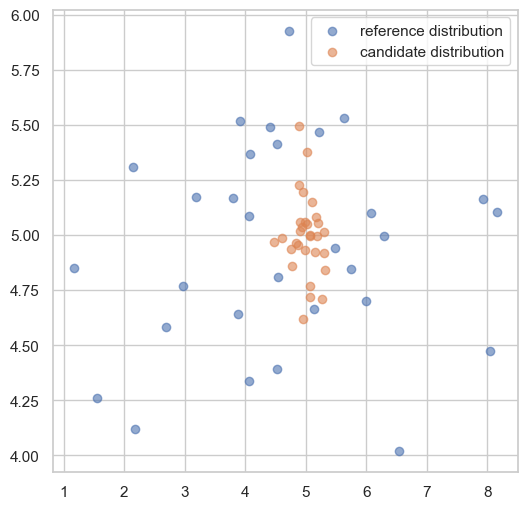

In [2]:
# generate a reference and candidate distribution in 2D
n_points = 30

reference_distribution = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
evaluated_distribution = np.array([np.random.normal(5, .2, n_points), np.random.normal(5, .2, n_points)]).T

plt.figure(figsize=(figsize, figsize))

plt.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
plt.scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='candidate distribution')

plt.legend()
plt.show()

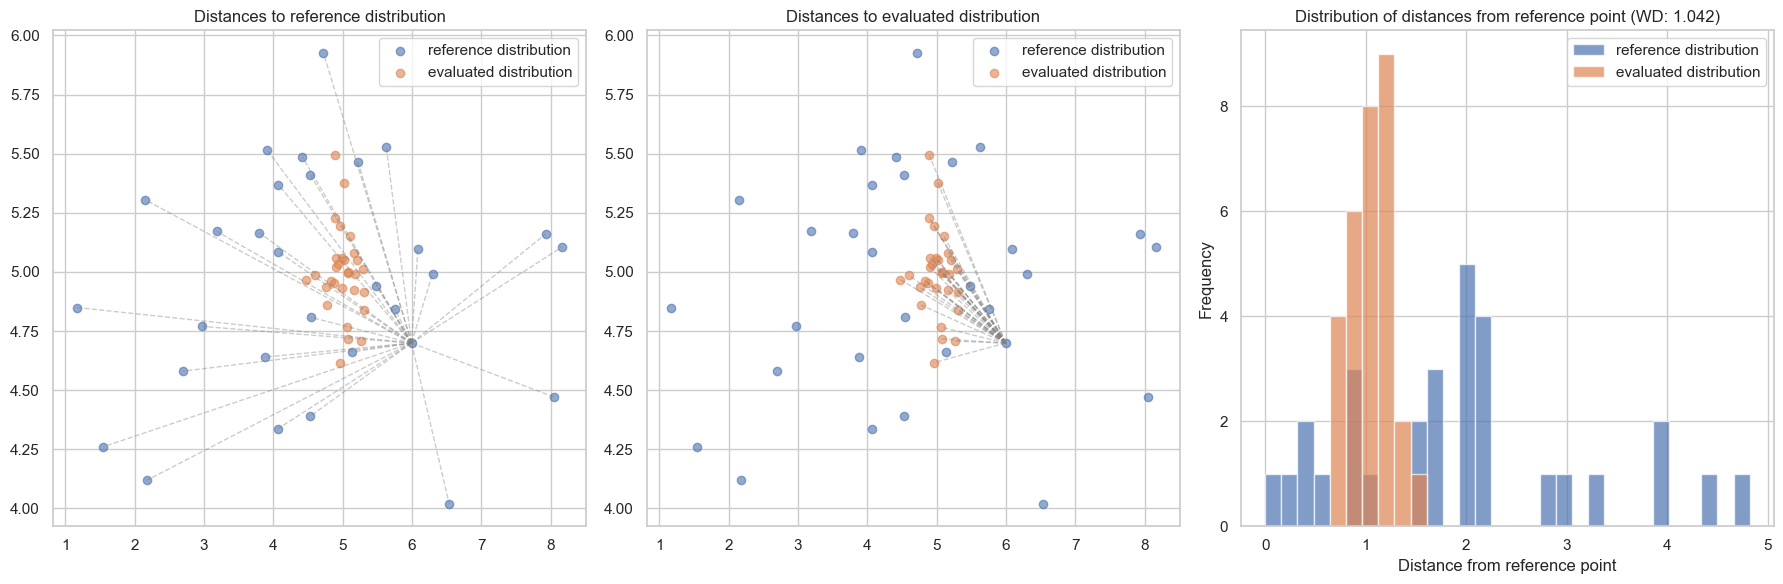

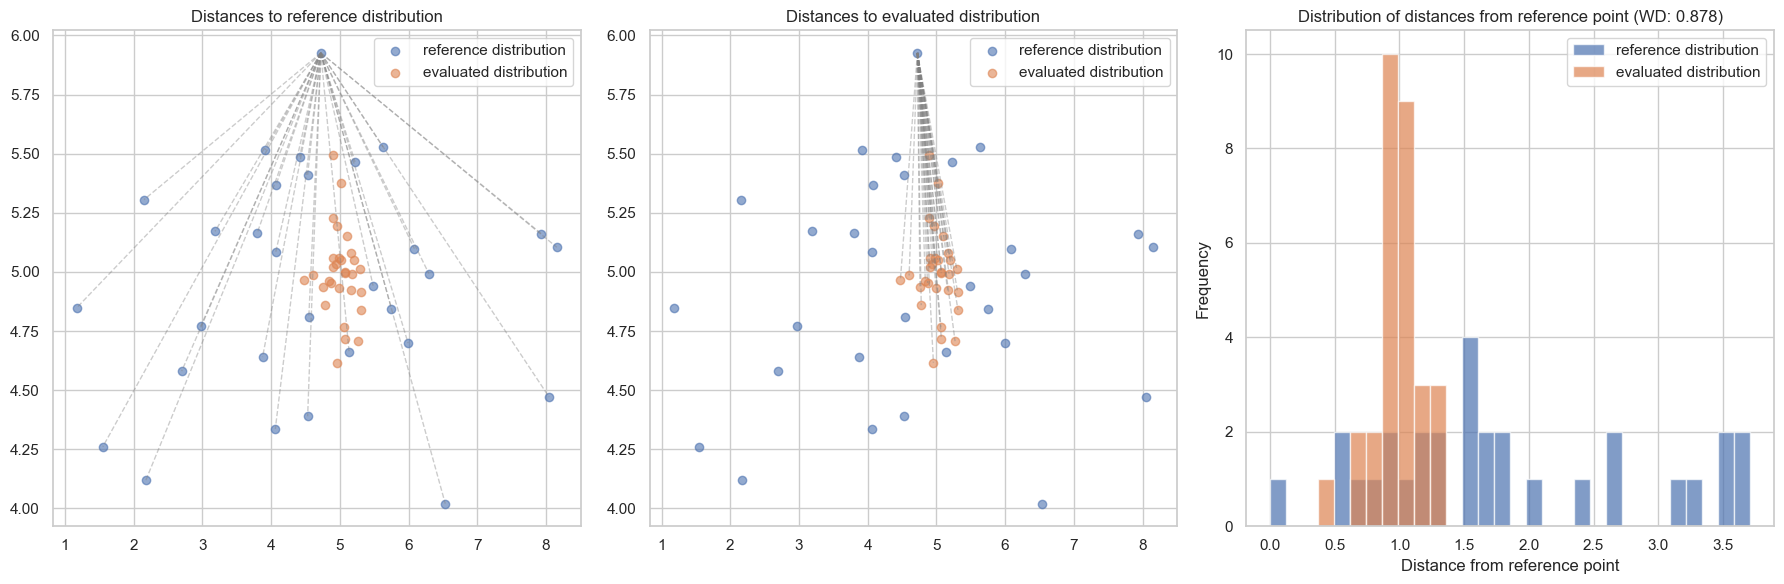

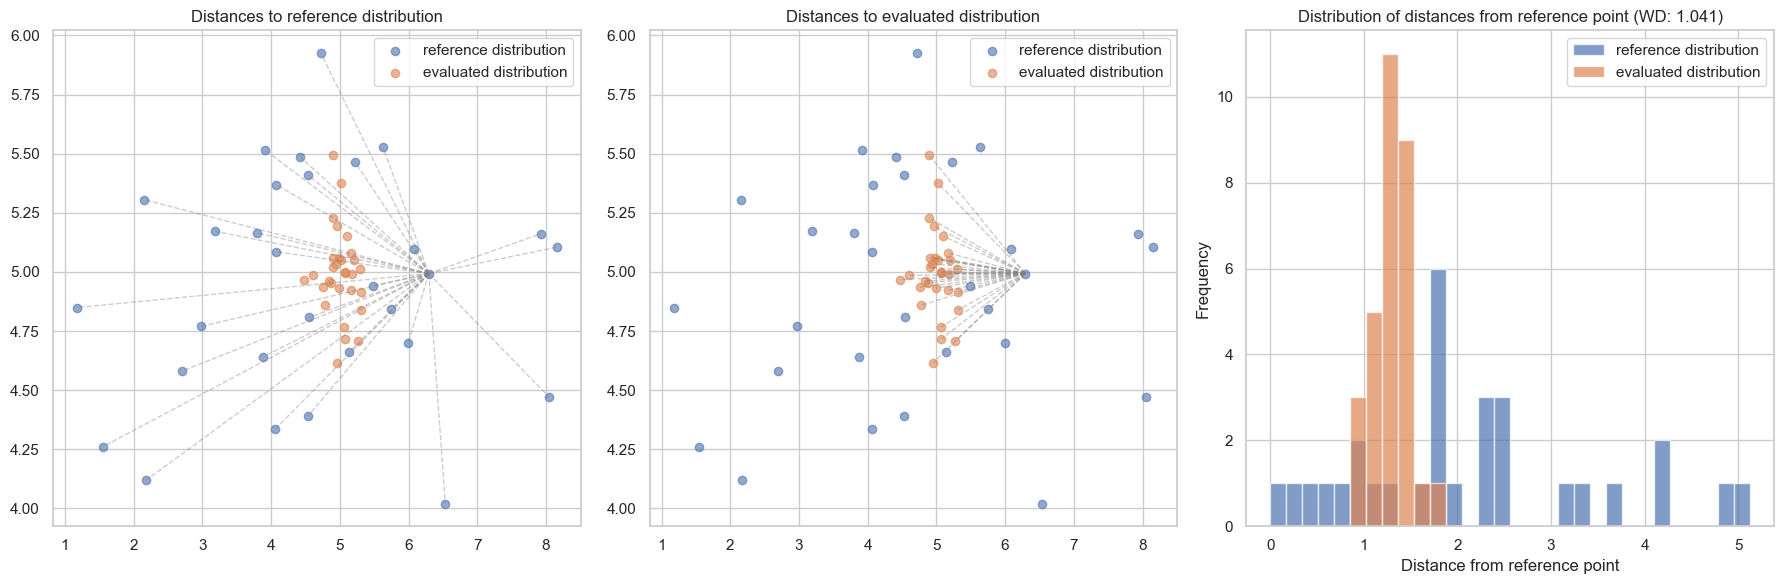

In [3]:
# the PED leverages every point in the reference samples to evaluate the average distance between empirical distributions;
# here we showcase how that looks like for a few of these points
for point_i in range(3):

    # 1) compute the distance between a reference point and the reference empirical distributions
    reference_point = reference_distribution[point_i]
    distances = np.linalg.norm(reference_distribution - reference_point, axis=1)

    plt.figure(figsize=(figsize*3, figsize))
    plt.subplot(1, 3, 1)
    
    for point in reference_distribution:
        plt.plot([reference_point[0], point[0]], [reference_point[1], point[1]], 'grey', linestyle='--', linewidth=1, alpha=.4)

    plt.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
    plt.scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='evaluated distribution')

    plt.legend(loc='upper right')
    plt.title('Distances to reference distribution')
    
    plt.subplot(1, 3, 2)
    
    # 2) compute the distance between the reference point and the evaluated empirical distributions
    distances = np.linalg.norm(reference_distribution - reference_point, axis=1)
    distances_eval = np.linalg.norm(evaluated_distribution - reference_point, axis=1)

    for point in evaluated_distribution:
        plt.plot([reference_point[0], point[0]], [reference_point[1], point[1]], 'grey', linestyle='--', linewidth=1, alpha=.4)

    plt.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
    plt.scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='evaluated distribution')

    plt.legend(loc='upper right')
    plt.title('Distances to evaluated distribution')

    plt.subplot(1, 3, 3)
    
    bins = np.histogram_bin_edges(np.concatenate([distances, distances_eval]), bins=n_points)

    plt.hist(distances, bins=bins, alpha=0.7, label='reference distribution')
    plt.hist(distances_eval, bins=bins, alpha=0.7, label='evaluated distribution')

    # 3) compare the two 1D distances distributions induced by the reference point
    wd = scipy.stats.wasserstein_distance(distances, distances_eval)

    plt.legend(loc='upper right')
    plt.xlabel('Distance from reference point')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of distances from reference point (WD: {wd:.3f})')
    
    plt.tight_layout()
    plt.show()



This metric in itself represents a divergence in expected distance distributions, and is not in general symmetric.  
By computing this quantity in the other direction we get a true distance.  

Note: for advanced applications in settings where one distribution is fixed we can leverage the divergence instead of the true distance to significantly reduce the computational burden by saving much more than half of the total calculations, however in general one will get more resolution leveraging the true distance.

In [4]:
# we can use any distance defined in the space of interest; if it is a true distance, then the resulting 
# metric will have the properties of a true distance as well; in this case we'll use the euclidean distance
def distances(points, point):
    return np.linalg.norm(points - point, axis=1)

# the pointwise empirical divergence can then be computed using any measure of distance between 1D distributions;
# in this notebook we'll use the wasserstein distance
def compute_ped(reference_samples, evaluated_samples):
    return np.mean([
        scipy.stats.wasserstein_distance(
            distances(reference_samples, reference_sample), 
            distances(evaluated_samples, reference_sample)
        ) 
        for reference_sample in reference_samples
    ])

# if we want to compute the complete pairwise empirical distance (CPED) to get the benefits of real distances,
# we can simply average the otherwise asymmetric divergence between the two distributions
def compute_cped(reference_distribution, evaluated_distribution):
    return np.mean([compute_ped(reference_distribution, evaluated_distribution), compute_ped(evaluated_distribution, reference_distribution)])

print(f'PED between reference and evaluated distributions: {compute_ped(reference_distribution, evaluated_distribution):.2f} (complete: {compute_cped(reference_distribution, evaluated_distribution):.2f})')
print(f'Wasserstein distance between reference and evaluated distributions: {scipy.stats.wasserstein_distance_nd(reference_distribution, evaluated_distribution):.2f}')

PED between reference and evaluated distributions: 1.01 (complete: 1.14)
Wasserstein distance between reference and evaluated distributions: 1.37


# Statistical interpretation

We can also use the PED to get a probability estimate of the two empirical distributions being generated from the same distribution.

In [5]:
def distances_distribution(samples, n_bootstrap = 1000):
    '''
    bootstrap pointwise empirical divergence of an empirical distribution with respect to itself bootstrapped;
    return the resulting distances distribution, alongside the computed theoretical distribution
    '''
    # gather empirical PEDs
    peds = np.array([
        compute_ped(
            samples[np.random.choice(len(samples), len(samples))], 
            samples[np.random.choice(len(samples), len(samples))]
        ) for i in range(n_bootstrap)
    ])

    # we approximate these with a Gamma distribution to reduce the number of bootstraps required
    gamma_distribution = scipy.stats.gamma(*scipy.stats.gamma.fit(peds))
    
    # return empirical and theoretical distribution
    return peds, gamma_distribution

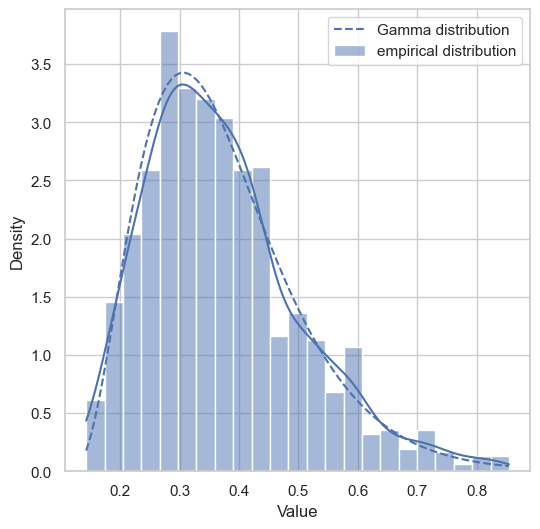

In [6]:
# compute empirical and Gamma distribution
peds, dist = distances_distribution(reference_distribution)

# plot empirical vs theoretical
plt.figure(figsize=(figsize, figsize))

# empirical distribution
sns.histplot(peds, stat='density', kde=True, label='empirical distribution', alpha=.5)

# theoretical distribution
x = np.linspace(min(peds), max(peds), 100)
plt.plot(x, dist.pdf(x), label='Gamma distribution', color='#4c72b0', linestyle='--')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

We can therefore use the CDF of the fitted distribution for the expected PED to evaluate the probability of observing distances equal to or greater than the one registered for the evaluated distribution

In [7]:
# compute prob of observing a distance equal to or higher than the one observed from the candidate to the reference distribution
pval = 1 - dist.cdf(compute_ped(reference_distribution, evaluated_distribution))
print(f'Probability of candidate samples sharing ground distribution with empirical {pval:.4f}')

Probability of candidate samples sharing ground distribution with empirical 0.0006


In order to fully leverage the PED we can consider it in two ways

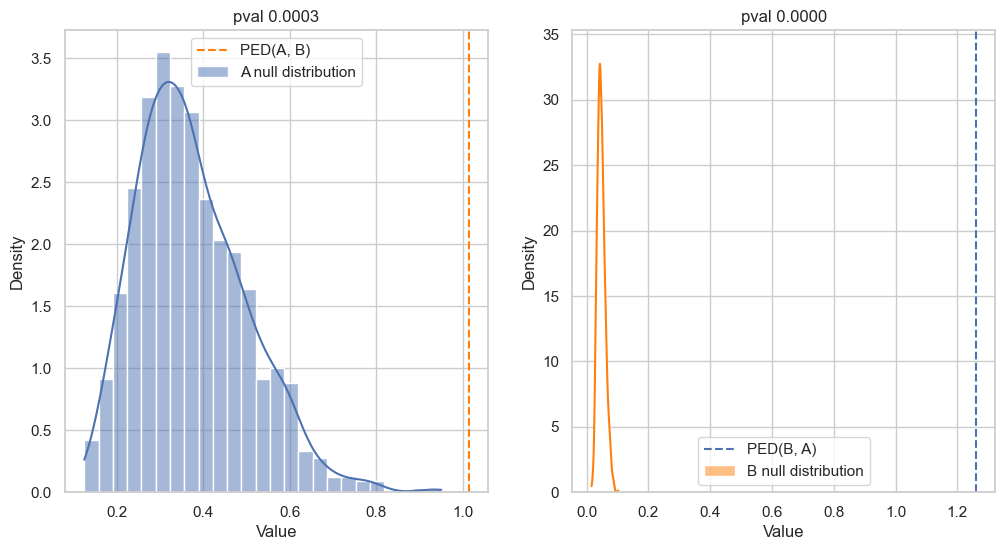

In [8]:
# reference vs self and candidate
reference_peds, reference_dist = distances_distribution(reference_distribution)
reference_candidate_ped = compute_ped(reference_distribution, evaluated_distribution)

# candidate vs self and reference
candidate_peds, candidate_dist = distances_distribution(evaluated_distribution)
candidate_reference_ped = compute_ped(evaluated_distribution, reference_distribution)

# plot empirical vs theoretical
plt.figure(figsize=(figsize*2, figsize))
plt.subplot(1, 2, 1)

# empirical distribution
sns.histplot(reference_peds, stat='density', kde=True, label='A null distribution')
plt.axvline(x=reference_candidate_ped, color='#ff7f0e', label='PED(A, B)', linestyle='--')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'pval { 1 - reference_dist.cdf(reference_candidate_ped):.4f}')
plt.legend()

plt.subplot(1, 2, 2)

# empirical distribution
sns.histplot(candidate_peds, stat='density', kde=True, label='B null distribution', color='#ff7f0e')

plt.axvline(x=candidate_reference_ped, color='#4c72b0', label='PED(B, A)', linestyle='--')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'pval { 1 - candidate_dist.cdf(candidate_reference_ped):.4f}')
plt.legend()

plt.show()

Since the two values are correlated, considering the best statistical approach to the individual information is not entirely trivial, and largely outside of the scope required by the Cytobench intended use cases (as we will later see)  
To simplify we will select the minimum pvalue between the two considered

In [9]:
def ground_pval(samples_a, samples_b, n_bootstrap = 1000):
    '''
    compare two PED null distributions, then return the lowest pval
    '''
    # get empirical and theoretical distributions
    peds_a, dist_a = distances_distribution(samples_a, n_bootstrap = n_bootstrap)
    peds_b, dist_b = distances_distribution(samples_b, n_bootstrap = n_bootstrap)
    
    # compute pvalue of B coming from A 
    ped_ab = compute_ped(samples_a, samples_b)
    pval_ab = 1 - dist_a.cdf(ped_ab)
    
    # compute pvalue of A coming from B
    ped_ba = compute_ped(samples_b, samples_a)
    pval_ba = 1 - dist_b.cdf(ped_ba)
    
    # return the minimum pval
    return min(pval_ab, pval_ba)

We document a few practical examples of how the pvalue might result from comparing different distributions (as well as cases in which the metric will fail)  
Note that in general there will be no correlation between pointwise empirical distances and probability of distributions being close together, as they pertain two entirely different domains  

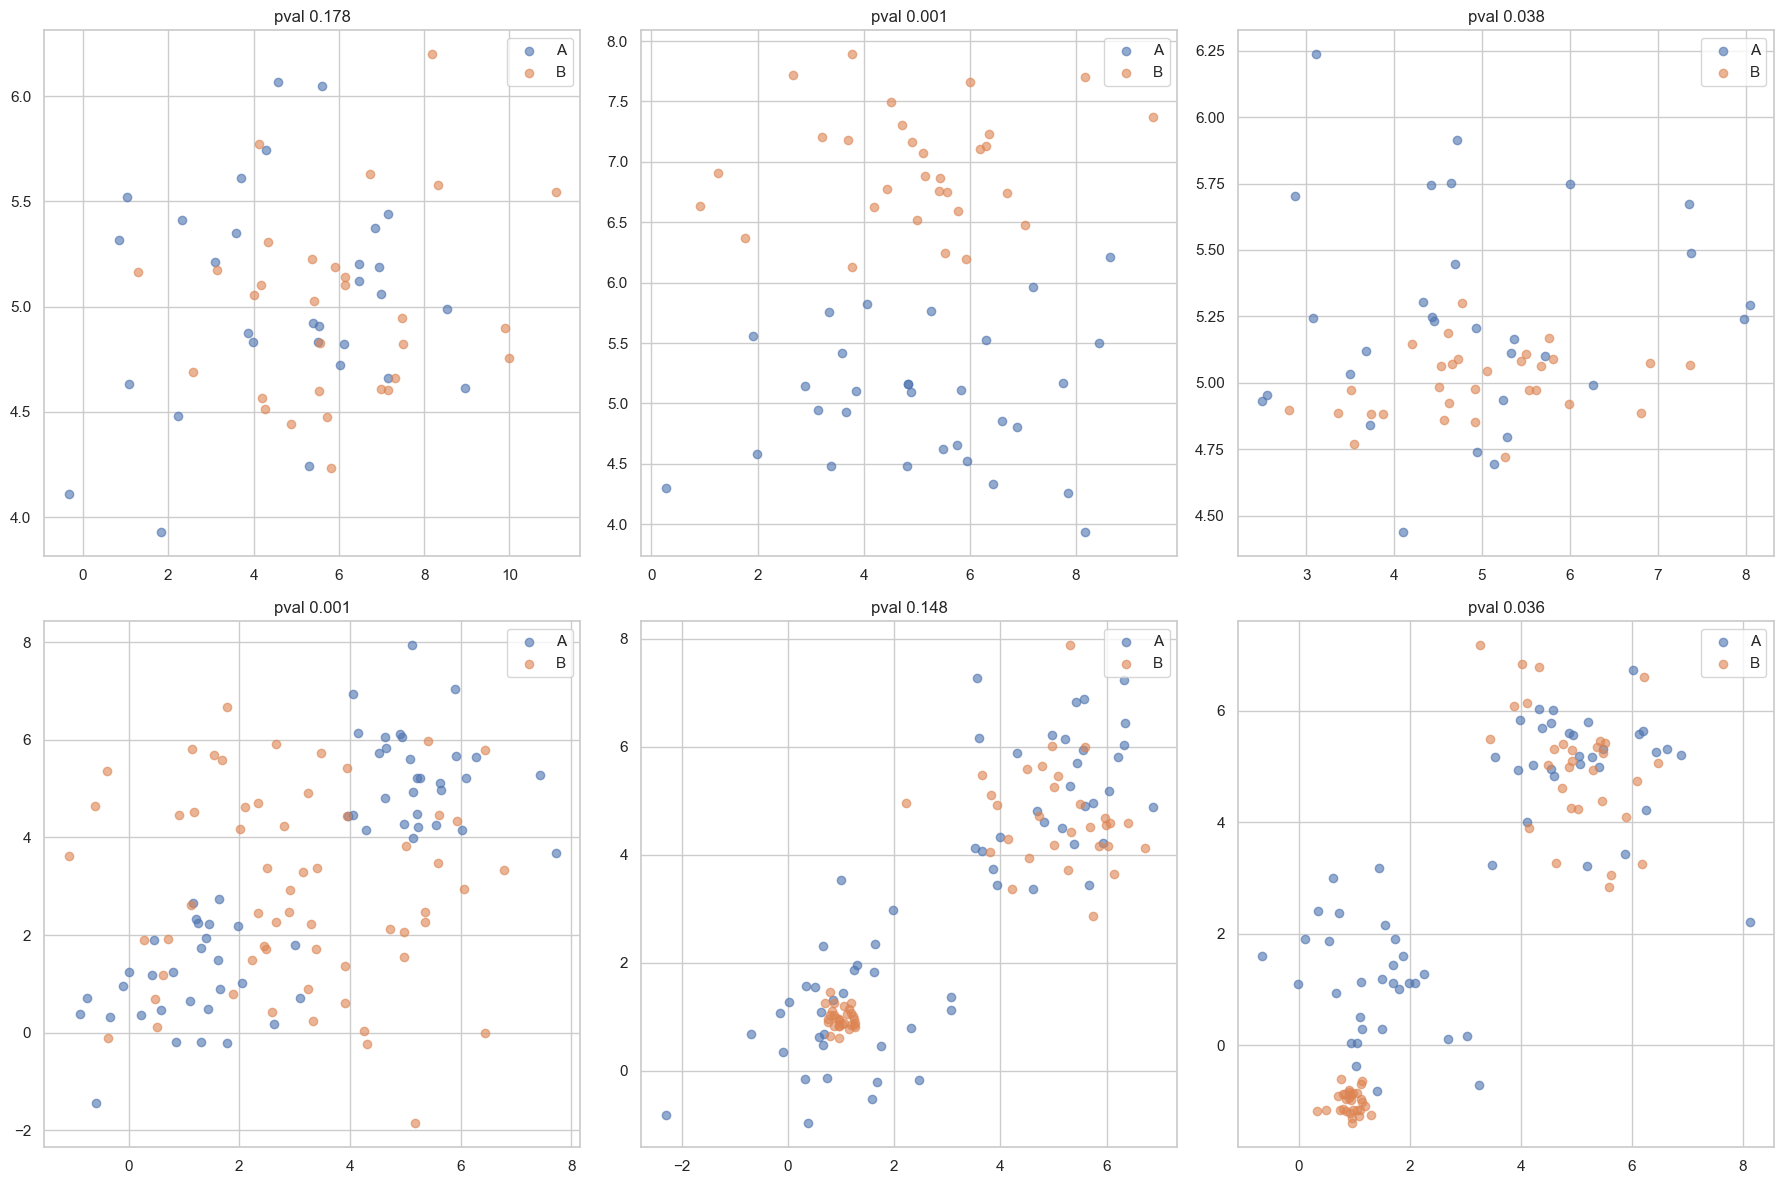

In [10]:
# list of normal distributions to compare
compare_dist = [
    
    # one element per example
    # for each example: reference and candidate
    # for each distribution: list of Gaussian mixtures
    # for each Gaussian: mean_x, mean_y, scale_x, scale_y
    
    [
        # identical distributions
        [[5, 5, 2, .5]],
        [[5, 5, 2, .5]],
    ],
    [
        # intersecting distributions
        [[5, 5, 2, .5]],
        [[5, 7, 2, .5]],
    ],
    [
        # concentric distributions
        [[5, 5, 2, .5]],
        [[5, 5, 1, .1]],
    ],
    
    [
        # multimodal vs unimodal
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[3, 3, 2, 2], [3, 3, 2, 2]],
    ],
    [
        # concentric multimodal distributions, hard case
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[5, 5, 1, 1], [1, 1, .2, .2]],
    ],
    [
        # concentric multimodal distributions, simple case
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[5, 5, 1, 1], [1, -1, .2, .2]],
        
    ],
]

# plot initial population expansion on a 2x3 grid, flattening the axes for ease of iteration
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

# increase sample size for visual clarity
n_samples = 60

for i in range(6):
    
    # sample points from distribution A
    dA = np.concatenate([
        np.array([np.random.normal(mean_x, scale_x, n_points), np.random.normal(mean_y, scale_y, n_points)]).T
        for mean_x, mean_y, scale_x, scale_y in compare_dist[i][0]
    ])
    
    # sample points from distribution B
    dB = np.concatenate([
        np.array([np.random.normal(mean_x, scale_x, n_points), np.random.normal(mean_y, scale_y, n_points)]).T
        for mean_x, mean_y, scale_x, scale_y in compare_dist[i][1]
    ])
    
    # compute pval
    pval = ground_pval(dA, dB)
    
    # plot distributions
    axes[i].scatter(dA[:,0], dA[:,1], alpha=0.6, label='A')
    axes[i].scatter(dB[:,0], dB[:,1], alpha=0.6, label='B')

    axes[i].legend(loc='upper right')
    axes[i].set_title(f'pval {pval:.3f}')

plt.tight_layout()
plt.show()

Following some PED examples on more exotic distributions to wrap up the notebook, feel free to expand and play around with the functions by adding more!

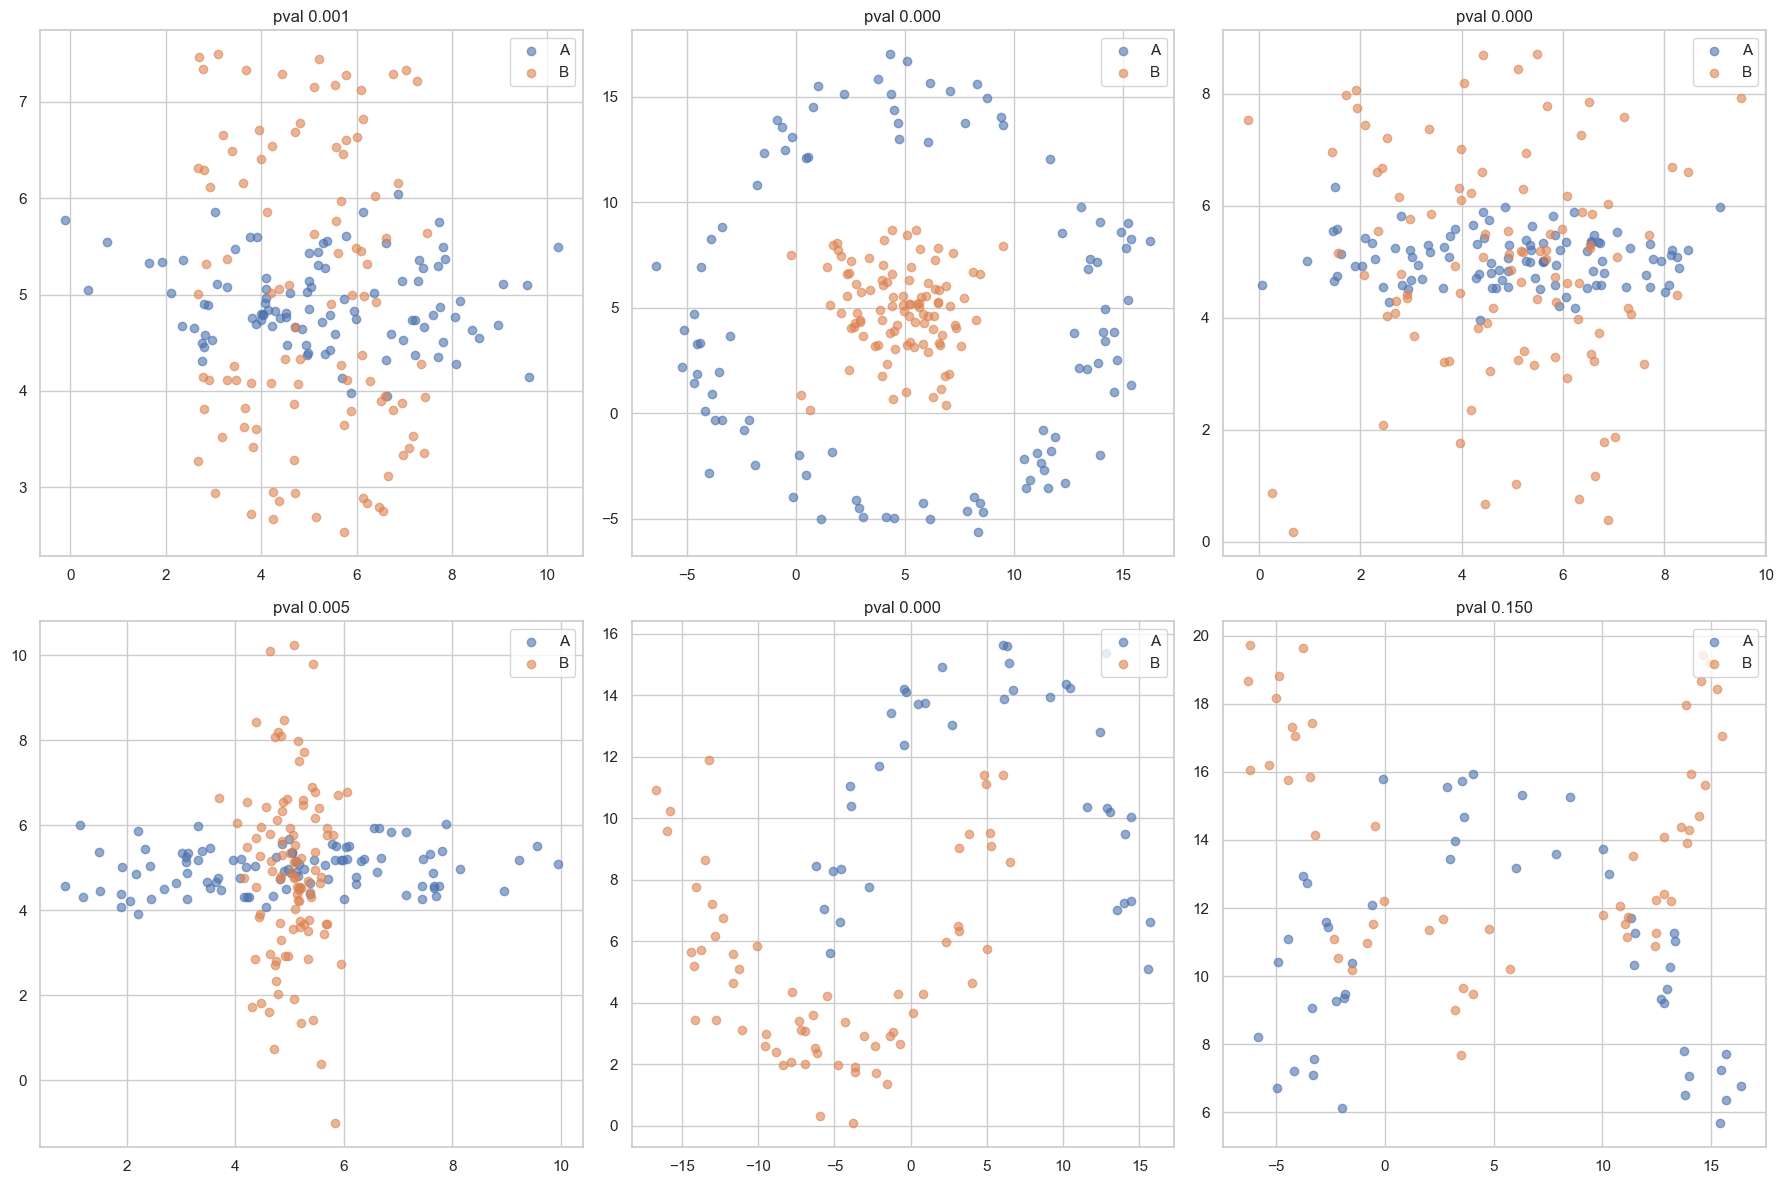

In [11]:
# extract plotting function from above
def compare_and_plot(axes, dA, dB):
    
    # compute PED and pval
    pval = ground_pval(dA, dB)
    
    # plot distributions
    axes.scatter(dA[:,0], dA[:,1], alpha=0.6, label='A')
    axes.scatter(dB[:,0], dB[:,1], alpha=0.6, label='B')

    axes.legend(loc='upper right')
    axes.set_title(f'pval {pval:.3f}')
    
# make some plots
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

n_points, plot_i = 100, 0

# uniform vs normal, simple
dA = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
dB = np.array([np.random.uniform(2.5, 7.5, n_points), np.random.uniform(2.5, 7.5, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# bullseye distribution
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)

dA = np.vstack((radii * np.cos(angles), radii * np.sin(angles))).T + 5
dB = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, 2, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# flattened bullseye
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)

dA = np.vstack((radii * np.cos(angles), radii * np.sin(angles))).T + 5
dA = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# uniform vs normal
dA = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
dB = np.array([np.random.normal(5, .5, n_points), np.random.normal(5, 2, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# non intersecting Us
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)
mask = angles < np.pi  # split into two distributions

dA = np.vstack((radii[mask] * np.cos(angles[mask]), radii[mask] * np.sin(angles[mask]))).T + 5
dB = np.vstack((radii[~mask] * np.cos(angles[~mask]), radii[~mask] * np.sin(angles[~mask]))).T + [-5, 12]

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# intersecting Us
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)
mask = angles < np.pi  # split into two distributions

dA = np.vstack((radii[mask] * np.cos(angles[mask]), radii[mask] * np.sin(angles[mask]))).T + 5
dB = np.vstack((radii[~mask] * np.cos(angles[~mask]), radii[~mask] * np.sin(angles[~mask]))).T + [5, 20]

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

plt.tight_layout()
plt.show()